In [ ]:
import os, sys

dir1 = os.path.abspath("..\..")
sys.path.append(dir1 + "\\")

import MetaTrader5 as mt
from datetime import datetime as dt

# custom
from my_jupyter.user import User
from my_jupyter.strategy_manager import StrategyManager
from my_jupyter.operation import Operation
from my_jupyter.strategies.min_max_strategy import MinMaxStrategy
from my_jupyter.market_data_repository import MarketDataRepository
from my_jupyter.filters.moving_average import MovingAverageFilter
from my_jupyter.filters.consequent_limits_counter import ConsequentLimitsCounterFilter
from my_jupyter.filters.directioned_bars_filter import DirectionedBarsFilter

# from Mbox import Mbox
# from boleta_1 import gerar_boleta
# from gerenciamento import Gerenciamento

## GUI's
from daemon_tools import DaemonThreadMini

In [ ]:
filters = [
    DirectionedBarsFilter(candles=5),
    MovingAverageFilter(),
    MovingAverageFilter(period=200),
]
strategies = [MinMaxStrategy(filters=filters)]
operations = [Operation("WINV23", 1, mt.TIMEFRAME_M1, can_buy=True, can_sell=True)]
user = User(
    strategies=strategies,
    operations=operations,
    trading_time_start=dt(2023, 10, 5, 9, 5, 0),
)
market_data_repository = MarketDataRepository()
strategy = StrategyManager(market_data_repository, user)

# PARAMETROS MAIN
kwargs = {
    "strategy": strategy,
}


def main(**kwargs):
    _shift = 0
    strategy: StrategyManager = kwargs["strategy"]
    strategy.run_strategies()
    # print(f"{dt.now().strftime('%d/%m/%Y, %H:%M:%S')} >>> D-{_shift}")


def exec_daemon(**kwargs):
    main(**kwargs)
    # alarme.ring_alarme()

In [ ]:
# gerenciamento = Gerenciamento(mt, timeframe, timeframes_dict)

try:
    main(**kwargs)
except Exception as e:
    print(e.with_traceback(__tb=None))
    # Mbox.Alerta("ERRO", "busca de sinais com erro")

In [ ]:
# from my_jupyter.daemons.daemon_tools import DaemonThreadMini


# thread_exec = DaemonThreadMini(exec_daemon, seconds=0, mseconds=800, **kwargs)
# thread_exec.start()

In [1]:
import os, sys

dir1 = os.path.abspath("..\..")
if dir1 not in sys.path:
    sys.path.append(dir1 + "\\")
from my_jupyter.modules.backtest_for_ml_module import EnumAct
from my_jupyter.indicator.bars_trend_quality_ml import (
    BarsTrendQualityML,
    NeuralNetworkModule,
)
from my_jupyter.market_data_repository import MarketDataRepository
from datetime import datetime as dt
import pandas as pd


bars_trend_ml = BarsTrendQualityML(quantity_of_bars_in_thousands=5)
bars_trend_ml.extract_data_for_modelling(
    from_stock_market_data="WIN$",
    quantity_previous_bar=5,
)
df = bars_trend_ml.df
# take_action=[EnumAct.BUY]

model_buy = NeuralNetworkModule()
model_buy.generate_model(df[df["act"]==EnumAct.BUY], 5, epochs=20)

# bars_trend_ml.extract_data_for_modelling(
#     from_stock_market_data="WIN$",
#     quantity_previous_bar=5,
# take_action=[EnumAct.SELL]
# )
model_sell = NeuralNetworkModule()
model_sell.generate_model(df[df["act"]==EnumAct.SELL], 5, epochs=20)

# bars_trend_ml.extract_data_for_modelling(
#     from_stock_market_data="WIN$",
#     quantity_previous_bar=5,
# take_action=[EnumAct.WAIT]
# )
model_wait = NeuralNetworkModule()
model_wait.generate_model(df[df["act"]==EnumAct.WAIT], 5, epochs=20)

c:\repo\python\financial-api\my_jupyter\modules\backtest_for_ml_module.py:36: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(


before filter 2145 2047 93301


c:\repo\python\financial-api\my_jupyter\modules\backtest_for_ml_module.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_min = curr[-1]


after filter 1356 1493 1352


In [15]:
from my_jupyter.market_data_repository import MarketDataRepository
from datetime import datetime as dt

import numpy as np


to_timestamp = lambda x: dt.fromtimestamp(x)
length_inputs = bars_trend_ml.quantity_previous_bar - 1


def define_input():
    mt_rep = MarketDataRepository()
    ohlc = mt_rep.mt.copy_rates_from_pos("WIN$", mt_rep.mt.TIMEFRAME_M1, 0, 200)
    ohlc_0_based = ohlc[::-1]
    ohlc_transform = [
        (
            ohlc_0_based[i : i + length_inputs]["close"],
            to_timestamp(ohlc_0_based[i]["time"]),
        )
        for i in range(0, len(ohlc_0_based) - length_inputs)
    ]
    # ohlc_transform = [ i - min(i) for i in ohlc_transform ]
    ohlc_transform = [
        {
            "in": ohlc_transform[i][0] - ohlc_transform[i][0][-1],
            "prices": ohlc_transform[i][0],
            "time": ohlc_transform[i][1],
        }
        for i in range(len(ohlc_transform))
    ]
    return ohlc_transform, ohlc_0_based


ohlc_transform, ohlc_0_based = define_input()


def take_result(ohlc_transform, model: NeuralNetworkModule):
    results = []
    input_on_model = [i["in"] for i in ohlc_transform] 
    outputs = model.output(input_on_model)
    for i in range(0, len(outputs)):
        results.append(
            {
                "out": outputs[i][0],
                "in": ohlc_transform[i]["prices"],
                "time": ohlc_transform[i]["time"],
            }
        )
    return results


output_buy = take_result(ohlc_transform, model_buy)
output_wait = take_result(ohlc_transform, model_wait)
output_sell = take_result(ohlc_transform, model_sell)

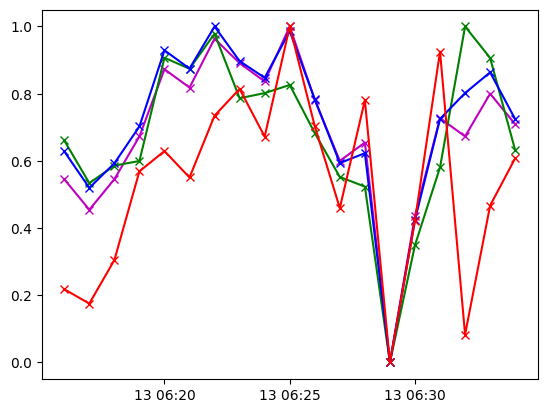

In [19]:
from matplotlib import pyplot as plt


def get_results(results):
    res_out = [results[i]["out"] for i in range(len(results))][::-1]
    res_out_time = [results[i]["time"] for i in range(len(results))][::-1]
    return res_out, res_out_time


results_buy, results_buy_time = get_results(output_buy)
results_wait, results_wait_time = get_results(output_wait)
results_sell, results_sell_time = get_results(output_sell)

ohlc_non_zero_based = ohlc_0_based[::-1][bars_trend_ml.quantity_previous_bar :]["close"]
ohlc_non_zero_based_time = list(
    map(to_timestamp, ohlc_0_based[::-1][bars_trend_ml.quantity_previous_bar :]["time"])
)

skips = 60
lasts = 20

ohlc_s = pd.Series(ohlc_non_zero_based, ohlc_non_zero_based_time)[
    : len(ohlc_non_zero_based) - skips
][-lasts:]

series_buy = pd.Series(results_buy, results_buy_time)[: len(results_buy) - skips][
    -lasts:
]
series_wait = pd.Series(results_wait, results_wait_time)[: len(results_wait) - skips][
    -lasts:
]
series_sell = pd.Series(results_sell, results_sell_time)[: len(results_sell) - skips][
    -lasts:
]

ohlc_s_diff = ohlc_s.diff().cumsum().dropna()
ohlc_norm = (ohlc_s_diff - min(ohlc_s_diff)) / (max(ohlc_s_diff) - min(ohlc_s_diff))
cumsum_buy = (series_buy + ohlc_s_diff).dropna()
cumsum_wait = (series_wait + ohlc_s_diff).dropna()
cumsum_sell = (series_sell +ohlc_s_diff).dropna()
norm_buy = (cumsum_buy - min(cumsum_buy)) / (max(cumsum_buy) - min(cumsum_buy)) 
norm_wait = (cumsum_wait - min(cumsum_wait)) / (max(cumsum_wait) - min(cumsum_wait)) 
norm_sell = (cumsum_sell - min(cumsum_sell)) / (max(cumsum_sell) - min(cumsum_sell))

plt.plot(ohlc_norm, "xm", ohlc_norm,"m")
plt.plot(norm_buy , "xg", norm_buy , "g")
plt.plot(norm_wait, "xb", norm_wait, "b")
plt.plot(norm_sell, "xr", norm_sell, "r")
plt.show()

In [56]:
def quantidade_de_acertos():
    res_s_diff = res_s.diff().dropna()
    trues = filter(lambda x: x, [i > 0 for i in res_s_diff * ohlc_s_diff])
    skips_ = filter(lambda x: x, [i == 0 for i in res_s_diff * ohlc_s_diff])
    falses = filter(lambda x: x, [i < 0 for i in res_s_diff * ohlc_s_diff])

    qnt_trues = len(list(trues))
    qnt_falses = len(list(falses))
    total = len(res_s_diff) - len(list(skips_))
    print(qnt_trues / total, qnt_falses / total)

0.5087719298245614 0.49122807017543857


57